In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from skimage import data, io

## Introduction

### SIFT Wafer Map

In [9]:
df = pd.read_pickle("../data/processed/WM811K/train_val_data.pkl.xz")
df

,waferMap,failureType,failureCode
21324,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Loc,4
30039,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Loc,4
45248,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Loc,4
30370,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Loc,4
27540,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Loc,4
...,...,...,...
28880,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Near-full,5
29003,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Near-full,5
18124,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25...",Near-full,5
55768,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25...",Near-full,5


Index([25325], dtype='int64')


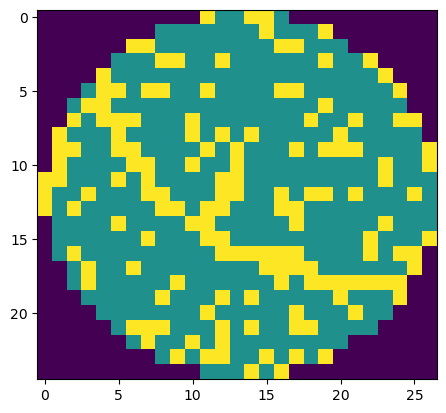

In [44]:
# Grab a random wafer map with a Scratch failureType
scratch_row = df[df["failureType"] == "Scratch"].sample(1)
print(scratch_row.index)

# Grab the wafer map and label
wafer = scratch_row.waferMap.values[0]
plt.imshow(wafer)

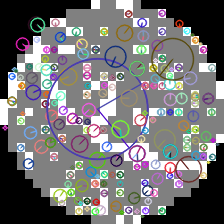

In [59]:
# wafer = df.loc[25325].waferMap
wafer = cv2.resize(wafer, (224, 224), interpolation=cv2.INTER_NEAREST_EXACT)

def draw_sift_keypoints(wafermap):
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(wafermap, None)
    img = cv2.drawKeypoints(
        wafermap, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )
    return img

img = draw_sift_keypoints(wafer)
pil_img = Image.fromarray(img)#.resize((512, 512), Image.NEAREST)
display(pil_img)
pil_img.save("../reports/figures/sift_wafer.png")

## Issues with annotation

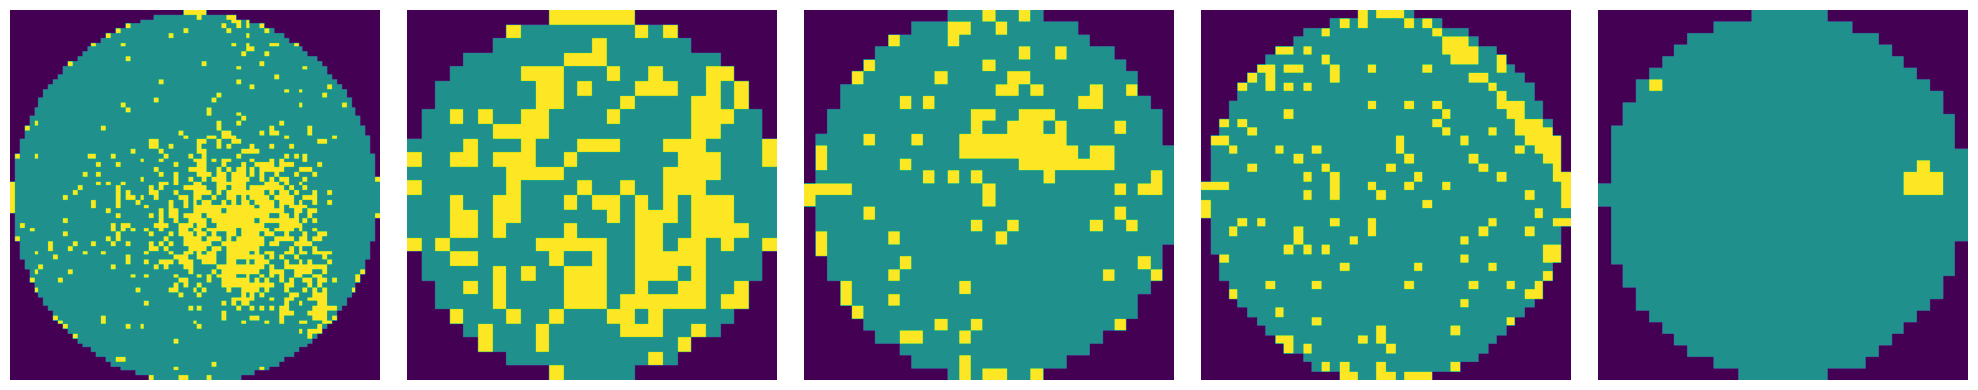

In [80]:
# Sample 5 wafers of the "Loc" failureType. Resize to 224x224 and plot in subplots
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, ax in enumerate(axes):
    wafer = df[df["failureType"] == "Loc"].sample(1).waferMap.values[0]
    wafer = cv2.resize(wafer, (224, 224), interpolation=cv2.INTER_NEAREST_EXACT)
    ax.imshow(wafer)
    # ax.set_title(f"Loc Wafer {i}")
    ax.set_axis_off()
plt.tight_layout()
plt.savefig("../reports/figures/loc_wafers.png", dpi=300)
plt.show()

## Masked Autoencoder: Patchify and Mask

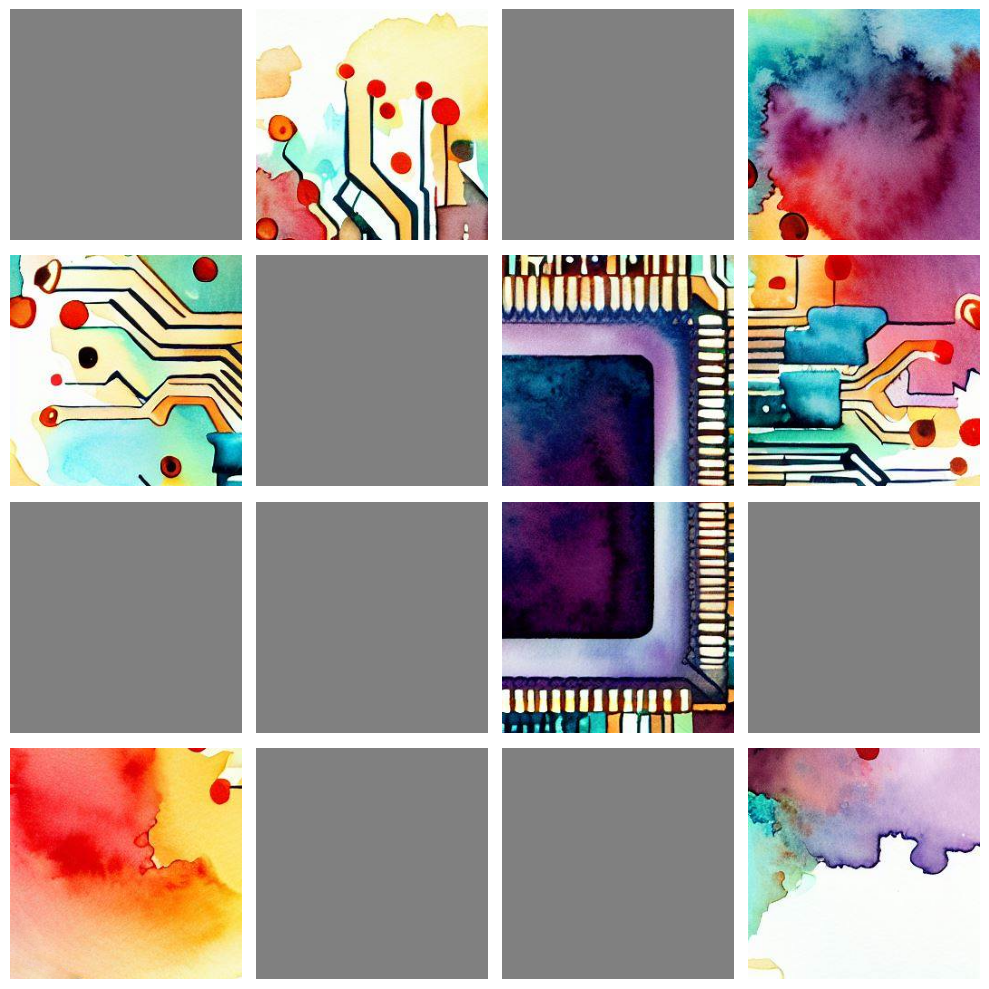

In [48]:
img = io.imread("../reports/figures/watercolor_chip.png")

# Divide the image into N x N patches
N = 4
patches = [
    img[x : x + img.shape[0] // N, y : y + img.shape[1] // N]
    for x in range(0, img.shape[0], img.shape[0] // N)
    for y in range(0, img.shape[1], img.shape[1] // N)
]

# Randomly select M of the patches (do this using indices to avoid issues)
M = 8
idx = np.random.choice(len(patches), M, replace=False)

# For these M patches, replace them all with masked out patches
# masked_patch will just be the same size, but all zeros
patches = [
    patches[i] if i not in idx else np.full_like(patches[i], 128)
    for i in range(len(patches))
]

# Now, plot the patches in subplots
fig, axes = plt.subplots(N, N, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(patches[i])
    ax.set_axis_off()
plt.tight_layout()
plt.savefig(
    "../reports/figures/watercolor_chip_masked.png", dpi=300, bbox_inches="tight"
)
plt.show()